In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ConfigParser import ConfigParser
import pandas as pd
from rlx import ml
%matplotlib inline

In [4]:
cfg = ConfigParser()
cfg.read("../config-raul.ini")
accidents_dir = cfg.get("dirs", "accidentes")
fetex_dir     = cfg.get("dirs", "fetex")
rm_dir        = cfg.get("dirs", "road_metrics")
grid_id       = cfg.get("grid", "default")
print "using", grid_id

using m250


# load files

### accidentes

In [5]:
def load_acc(accidents_dir, grid_id):
    acc = pd.read_csv("%s/%s_c.csv"%(accidents_dir, grid_id))
    acc.set_index("id", inplace=True)
    return acc
#acc = load_acc(accidents_dir, grid_id)
#acc.head()

### fetex

In [6]:
def load_fetex(fetex_dir, grid_id, acc):
    fx = pd.read_csv("%s/r_fetex_%s.txt"%(fetex_dir, grid_id))
    fx.set_index("ID", inplace=True)
    x = (acc.xmax+acc.xmin)/2.
    y = (acc.ymax+acc.ymin)/2.
    xy = pd.DataFrame([x,y], index=["x", "y"]).T
    fx = fx.join(xy)
    fx = fx[[i for i in fx.columns if i!="PROCESSED" and i!="SAMPLE"]]
    return fx
#fx = load_fetex(fetex_dir, grid_id, ac)
#fx.head()

In [7]:
def load_rm(rm_dir, grid_id):
    mm = pd.read_csv("%s/%s.csv"%(rm_dir, grid_id), sep=";")
    mm.columns = [i.strip() for i in mm.columns]
    mm.set_index("Id", inplace=True)
    print "WARNING!!!! there are %d 'ERROR EN EJECUCION' which have been removed"%(sum(mm.circuity_avg=="ERROR EN EJECUCION"))

    mm = mm.dropna()

    # fix type (had ERROR DE EJECUCION)
    mm["circuity_avg"]=mm["circuity_avg"].astype(float)

    # fix initities to max value
    k = mm.circuity_avg.values
    k[k==np.inf] = np.max(k[k!=np.inf])
    
    mm["circuity_avg"] = k
    
    return mm

#mm = load_rm(rm_dir, grid_id)
#mm.head()

In [8]:
def load_labs(grid_id):
    labs = pd.read_csv("../support_data/labels_4classes_%s.csv"%grid_id)
    labs.set_index("id", inplace=True)
    return labs
#labs = load_labs(grid_id)
#print labs.label.value_counts()
#labs.head()

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def lcurve_2_estimators(estimator1, estimator2, X,y, title_prefix=""):
    print "data sizes", X.shape, y.shape
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    cvs = [StratifiedShuffleSplit(n_splits=5, test_size=i) for i in np.linspace(.1,.9,9)]
    rs = ml.lcurve (cvs=cvs, estimator=estimator1, X=X, y=y, 
                    scorer = make_scorer(accuracy_score), n_jobs=5, verbose=50)
    ml.plot_lcurve(rs)
    plt.title(title_prefix+estimator1.__class__.__name__)
    plt.subplot(122)
    from sklearn.naive_bayes import GaussianNB
    cvs = [StratifiedShuffleSplit(n_splits=5, test_size=i) for i in np.linspace(.1,.9,9)]
    rs = ml.lcurve (cvs=cvs, estimator=estimator2, X=X, y=y, 
                    scorer = make_scorer(accuracy_score), n_jobs=5, verbose=50)
    ml.plot_lcurve(rs)
    plt.title(title_prefix+estimator2.__class__.__name__)
    

def train_cm(estimator,X,y, test_size):

    from sklearn.model_selection import train_test_split

    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    estimator.fit(Xtr,ytr)
    p = estimator.predict(Xts)
    cm = ml.confusion_matrix(yts, p)
    
    ac = cm.values.diagonal()/cm.sum(axis=1)
    return cm, ac

def train_acc(estimator, X,y, test_size, n_times):
    from rlx.utils import pbar
    test_size = 0.5
    n_times = 5
    r = []
    for i in pbar()(range(n_times)):
        Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
        estimator.fit(Xtr,ytr)
        p  = estimator.predict(Xts)
        cm = ml.confusion_matrix(yts, p)    
        ac = cm.values.diagonal()/cm.sum(axis=1)

        r.append(ac)
    means = pd.DataFrame(r).mean(axis=0)
    stds  = pd.DataFrame(r).std(axis=0)
    d     = pd.DataFrame([means, stds], index=["mean acc", "std acc"]).T
    d.index.name = "class"
    return d

def get_Xy_fetex(fx,labs):
    X = fx.values
    y = labs.label.values
    return X,y

def get_Xy_road_metrics(mm,labs):
    idxs = np.r_[list(set(labs.index).intersection(set(mm.index)))]
    print "using %d data points out of %d"%(len(idxs), len(labs))
    X = mm.loc[idxs].values
    y = labs.loc[idxs].label.values
    return X,y

def get_Xy_combined(fx,mm,labs):
    idxs = np.r_[list(set(labs.index).intersection(set(mm.index)))]
    print "using %d data points out of %d"%(len(idxs), len(labs))
    X = mm.join(fx).loc[idxs].values
    y = labs.loc[idxs].label.values
    return X,y

In [21]:
def exp_lcurve(grid_id, accidents_dir, fetex_dir, rm_dir):
    acc  = load_acc(accidents_dir, grid_id)
    fx   = load_fetex(fetex_dir, grid_id, acc)
    mm   = load_rm(rm_dir, grid_id)
    labs = load_labs(grid_id)

    rf = RandomForestClassifier()
    gs = GaussianNB()

    X,y = get_Xy_fetex(fx,labs)    
    lcurve_2_estimators(rf, gs, X,y, "fetex ")    
    
    X,y = get_Xy_road_metrics(mm,labs)
    lcurve_2_estimators(rf, gs, X,y, "road_matrix ")
    
    X,y = get_Xy_combined(fx,mm,labs)
    lcurve_2_estimators(rf, gs, X,y, "combined ")

    X,y = get_Xy_combined(fx,mm,labs)
    n_components = 5
    e1 = Pipeline([("PCA", PCA(n_components=n_components)), ("RF", RandomForestClassifier())])
    e2 = Pipeline([("PCA", PCA(n_components=n_components)), ("RF", GaussianNB())])
    lcurve_2_estimators(e1, e2, X,y, "combined PCA %d comps "%n_components)


# learning curves at m250

WARNING!!!! there are 341 'ERROR EN EJECUCION' which have been removed
data sizes (1806, 36) (1806,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.3s finishedg:    0.0s10.using 1465 data points out of 1806
data sizes (1465, 16) (1465,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.3s finishedg:    0.0s6.using 1465 data points out of 1806
data sizes (1465, 52) (1465,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.6s finishedg:    0.0s4.using 1465 data points out of 1806
data sizes (1465, 52) (1465,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    1.8s finishedg:    0.0s2.

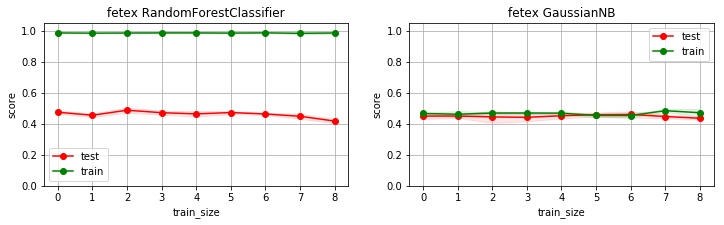

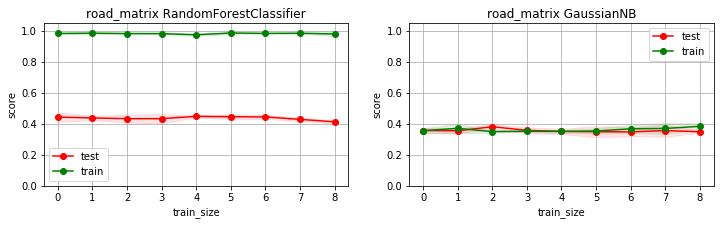

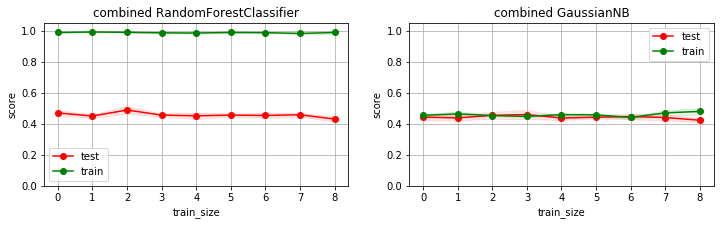

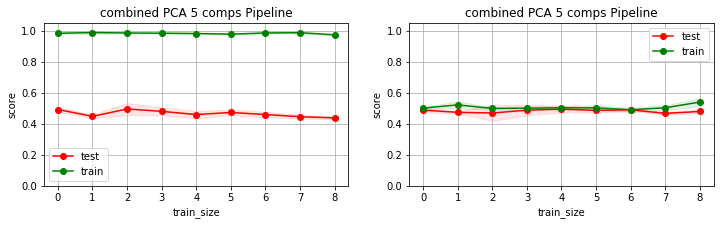

In [22]:
exp_lcurve("m250", accidents_dir, fetex_dir, rm_dir)

# learning curves at m350

WARNING!!!! there are 104 'ERROR EN EJECUCION' which have been removed
data sizes (954, 36) (954,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.3s finishedg:    0.0s12.using 850 data points out of 954
data sizes (850, 16) (850,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finishedg:    0.0s18.using 850 data points out of 954
data sizes (850, 52) (850,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.4s finishedg:    0.0s8.using 850 data points out of 954
data sizes (850, 52) (850,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.6s finishedg:    0.0s4.

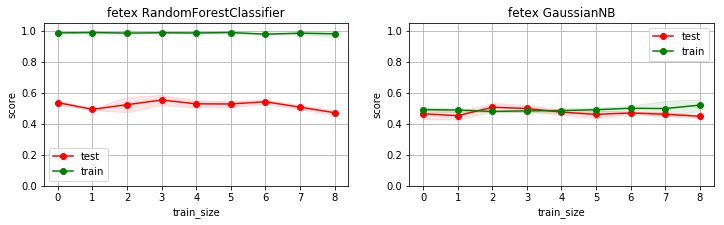

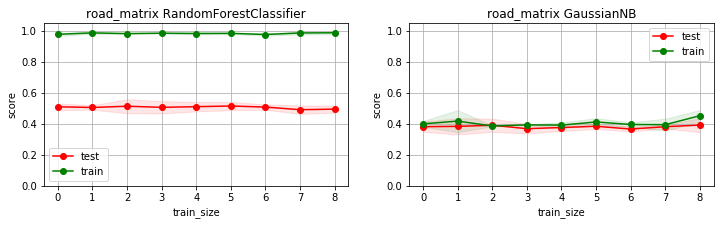

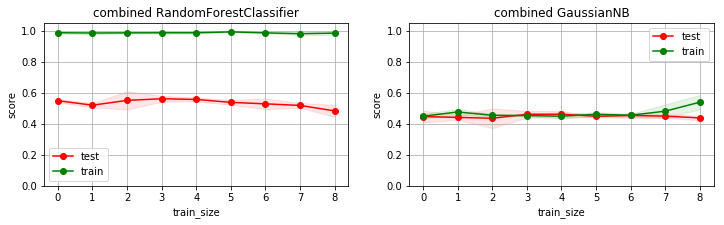

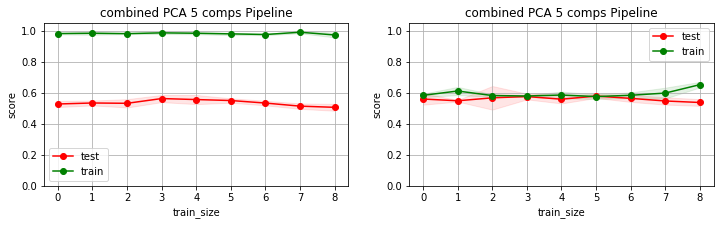

In [23]:
exp_lcurve("m350", accidents_dir, fetex_dir, rm_dir)

# learning curves at m500

WARNING!!!! there are 23 'ERROR EN EJECUCION' which have been removed
data sizes (482, 36) (482,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finishedg:    0.0s14.using 459 data points out of 482
data sizes (459, 16) (459,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finishedg:    0.0s18.using 459 data points out of 482
data sizes (459, 52) (459,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finishedg:    0.0s10.using 459 data points out of 482
data sizes (459, 52) (459,)
 [mParallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.7s finishedg:    0.0s4.

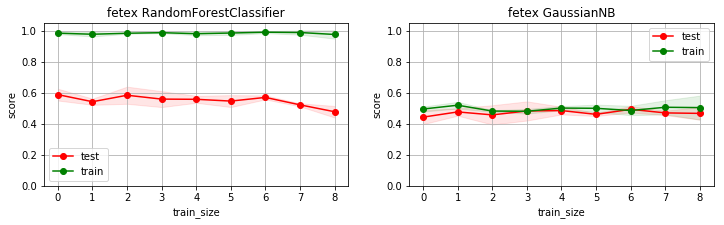

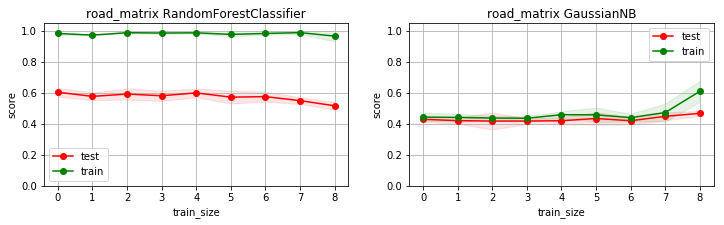

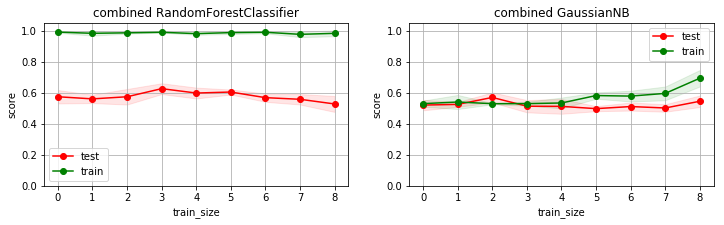

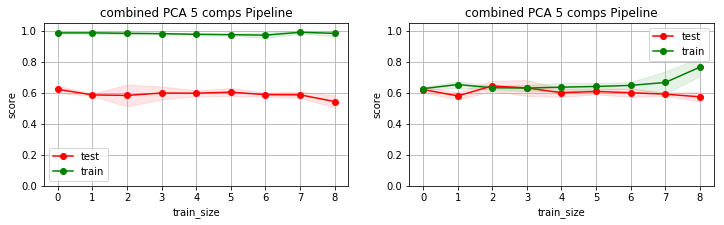

In [24]:
exp_lcurve("m500", accidents_dir, fetex_dir, rm_dir)

In [38]:
def exp2_acc(grid_id, accidents_dir, fetex_dir, rm_dir):
    acc  = load_acc(accidents_dir, grid_id)
    fx   = load_fetex(fetex_dir, grid_id, acc)
    mm   = load_rm(rm_dir, grid_id)
    labs = load_labs(grid_id)

    X,y  = get_Xy_combined(fx,mm,labs)
    k    = train_acc(RandomForestClassifier(), X, y, test_size=0.5, n_times=5)
    return k

## per class accuracy m250


In [39]:
exp2_acc("m250", accidents_dir, fetex_dir, rm_dir)

WARNING!!!! there are 341 'ERROR EN EJECUCION' which have been removed
using 1465 data points out of 1806


100% (5 of 5) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


,mean acc,std acc
class,,
0,0.275851,0.048606
1,0.411552,0.058284
2,0.424171,0.064235
3,0.620498,0.059542


## per class accuracy m350

In [40]:
exp2_acc("m350", accidents_dir, fetex_dir, rm_dir)

WARNING!!!! there are 104 'ERROR EN EJECUCION' which have been removed
using 850 data points out of 954


100% (5 of 5) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


,mean acc,std acc
class,,
0,0.277140,0.093705
1,0.533928,0.028229
2,0.553284,0.012655
3,0.603997,0.057576


## per class accuracy m500

In [41]:
exp2_acc("m500", accidents_dir, fetex_dir, rm_dir)

WARNING!!!! there are 23 'ERROR EN EJECUCION' which have been removed
using 459 data points out of 482


100% (5 of 5) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


,mean acc,std acc
class,,
0,0.272804,0.112583
1,0.580230,0.090621
2,0.560335,0.056203
3,0.708101,0.076870
